## Assignment 10 - Custom ResNet
In this assignment, for training CIFAR-10 dataset, Custom ResNet architecutre, Data Augmentation (Padding, RadnomCrop, Cutout, Horizontal Flip) and One Cycle LR policy are used to train teh model in 24 epochs and achieved 90.51% Test Accuracy . Developed APIs so as to load data, train, test and show results.

Following changes are done:

1. Added Data Augmentations (Albumentatons)

i. Padding (4)

ii. RandomCrop

iii. Cutout

iv. Horizontal Flip

2. Plotted the Cyclic LR over iterations

3. Performed LR Range Test for various maximum LR values for test accuracy in 5 epochs

4. Used One Cycle learning strategey for scheduling learning rates

Got best test accuracy: 90.51%


In [1]:
%matplotlib inline
#import autoreload
%load_ext autoreload
%autoreload

In [2]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to c:\users\shivs\appdata\local\temp\pip-req-build-eq1uitxe
  Resolved https://github.com/albu/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations 'C:\Users\shivs\AppData\Local\Temp\pip-req-build-eq1uitxe'


## Import all the libraries

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from data_transformations.data_transform_cifar10_custom_resnet import get_train_transform, get_test_transform
from data_loaders.cifar10_data_loader import get_train_loader, get_test_loader, get_classes
from models.CustomResNet import CustomResNet
from utils.train_test_utils import train,test
from utils.accuracy_utils import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics_utils import plot_loss_accuracy,plot_accuracy,plot_max_lr_vs_test_accuracy

from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images
from utils.gradcamkz_util import GRADCAM, PLOT,PLOTGRADCAM
from utils.gradcamkz_util import process_for_grad_cam
from utils.cyclic_lr_util import triangle_lr_plot,custom_one_cycle_lr, max_lr_finder_schedule

## PLOT CYCLIC LR

In this step, cyclic LR  is plotted over iterations. In this example, minimum LR =0.01, maximum LR =0.4, Step size = 10, Number of Iterations = 100 are used

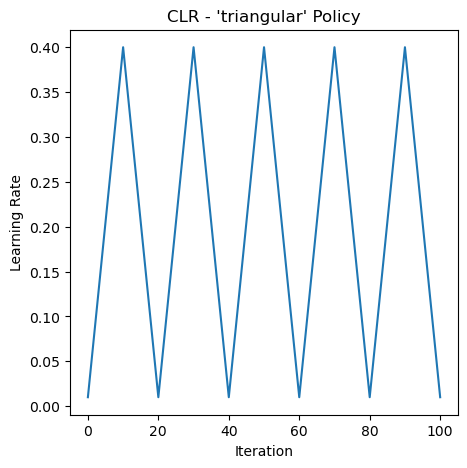

In [5]:
triangle_lr_plot(0.01, 0.4, 10, 100)


Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing CIFAR10

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [6]:
from models.main import train_test_loader,imshow, get_model,find_lr_value, train_model

In [7]:
BATCH_SIZE=512
trainloader, testloader, classes,transform_train,transform_test = train_test_loader(BATCH_SIZE,get_train_transform, get_test_transform,get_train_loader, get_test_loader, get_classes)

G:\anaconda3\lib\site-packages\albumentations\augmentations\dropout\cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


## Visualizing some of the images in train dataset



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship plane  frog  frog


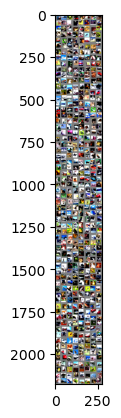

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) #.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

I have defined the custom ResNet18 model 



In [9]:
!pip install torchsummary
from torchsummary import summary

model = get_model(CustomResNet)
print(model)
summary(model, input_size=(3, 32, 32))

CustomResNet(
  (conv): ConvBNBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_out): Dropout2d(p=0.0, inplace=False)
  )
  (layer1): ResBlock(
    (transition_block): TransitionBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_out): Dropout2d(p=0.0, inplace=False)
    )
    (conv_block1): ConvBNBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_out): Dropout2d(p=0.0, inplace=False)
    )
    (conv_block2): ConvBNBlock(
      (conv): Conv2d(128, 1

G:\ERA_S10\models\CustomResNet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## LR Range Test

In this step, a ranges of maximum Learning Rate values are searched for which gives good test accuracy in 5 epochs.

In [10]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import os

model = get_model(CustomResNet)
PATH_BASE_MODEL = 'base_weights_lr_range_test.pth'
torch.save(model.state_dict(), PATH_BASE_MODEL)
EPOCHS_TO_TRY = 5
max_lr_list = [0.001, 0.004, 0.008, 0.01,0.04,0.08,0.1,0.4,0.8,1,2,4]
test_accuracy_list = []
find_lr_value(model,EPOCHS_TO_TRY,max_lr_list,test_accuracy_list,PATH_BASE_MODEL,max_lr_finder_schedule,BATCH_SIZE,train,test,trainloader,testloader)

MAX LR: 0.001  EPOCH: 1


Loss=2.95969295501709 Batch_id=97 Accuracy=9.97: 100%|█████████████████████████████████| 98/98 [20:10<00:00, 12.35s/it]



Test set: Average loss: 2.9081, Accuracy: 998/10000 (9.98%)

MAX LR: 0.001  EPOCH: 2


Loss=2.853879690170288 Batch_id=97 Accuracy=10.02: 100%|███████████████████████████████| 98/98 [20:39<00:00, 12.65s/it]



Test set: Average loss: 2.8898, Accuracy: 1000/10000 (10.00%)

MAX LR: 0.001  EPOCH: 3


Loss=2.7614848613739014 Batch_id=97 Accuracy=10.06: 100%|██████████████████████████████| 98/98 [21:43<00:00, 13.31s/it]



Test set: Average loss: 2.8520, Accuracy: 997/10000 (9.97%)

MAX LR: 0.001  EPOCH: 4


Loss=2.807123899459839 Batch_id=97 Accuracy=10.02: 100%|███████████████████████████████| 98/98 [20:55<00:00, 12.81s/it]



Test set: Average loss: 2.8175, Accuracy: 997/10000 (9.97%)

MAX LR: 0.001  EPOCH: 5


Loss=2.77701735496521 Batch_id=97 Accuracy=10.03: 100%|████████████████████████████████| 98/98 [21:15<00:00, 13.02s/it]



Test set: Average loss: 2.7714, Accuracy: 999/10000 (9.99%)

 For Max LR:  0.001  Test Accuracy:  9.99
MAX LR: 0.004  EPOCH: 1


Loss=2.676058530807495 Batch_id=97 Accuracy=10.02: 100%|███████████████████████████████| 98/98 [21:17<00:00, 13.04s/it]



Test set: Average loss: 2.7602, Accuracy: 995/10000 (9.95%)

MAX LR: 0.004  EPOCH: 2


Loss=2.682999849319458 Batch_id=97 Accuracy=10.11: 100%|███████████████████████████████| 98/98 [19:28<00:00, 11.93s/it]



Test set: Average loss: 2.5905, Accuracy: 1006/10000 (10.06%)

MAX LR: 0.004  EPOCH: 3


Loss=2.468860387802124 Batch_id=97 Accuracy=10.70: 100%|███████████████████████████████| 98/98 [20:24<00:00, 12.50s/it]



Test set: Average loss: 2.4650, Accuracy: 1116/10000 (11.16%)

MAX LR: 0.004  EPOCH: 4


Loss=2.412851333618164 Batch_id=97 Accuracy=11.42: 100%|███████████████████████████████| 98/98 [22:50<00:00, 13.98s/it]



Test set: Average loss: 2.3828, Accuracy: 1265/10000 (12.65%)

MAX LR: 0.004  EPOCH: 5


Loss=2.3107709884643555 Batch_id=97 Accuracy=12.96: 100%|██████████████████████████████| 98/98 [28:26<00:00, 17.41s/it]



Test set: Average loss: 2.3259, Accuracy: 1405/10000 (14.05%)

 For Max LR:  0.004  Test Accuracy:  14.05
MAX LR: 0.008  EPOCH: 1


Loss=2.513887405395508 Batch_id=97 Accuracy=10.17: 100%|████████████████████████████| 98/98 [9:34:48<00:00, 351.92s/it]



Test set: Average loss: 2.5357, Accuracy: 1051/10000 (10.51%)

MAX LR: 0.008  EPOCH: 2


Loss=2.356536388397217 Batch_id=97 Accuracy=11.73: 100%|███████████████████████████████| 98/98 [18:18<00:00, 11.21s/it]



Test set: Average loss: 2.3538, Accuracy: 1322/10000 (13.22%)

MAX LR: 0.008  EPOCH: 3


Loss=2.24723219871521 Batch_id=97 Accuracy=14.01: 100%|████████████████████████████████| 98/98 [18:14<00:00, 11.16s/it]



Test set: Average loss: 2.2699, Accuracy: 1610/10000 (16.10%)

MAX LR: 0.008  EPOCH: 4


Loss=2.24385404586792 Batch_id=97 Accuracy=16.65: 100%|████████████████████████████████| 98/98 [18:16<00:00, 11.19s/it]



Test set: Average loss: 2.2102, Accuracy: 1883/10000 (18.83%)

MAX LR: 0.008  EPOCH: 5


Loss=2.215841293334961 Batch_id=97 Accuracy=19.26: 100%|███████████████████████████████| 98/98 [19:03<00:00, 11.67s/it]



Test set: Average loss: 2.1561, Accuracy: 2170/10000 (21.70%)

 For Max LR:  0.008  Test Accuracy:  21.7
MAX LR: 0.01  EPOCH: 1


Loss=2.4330759048461914 Batch_id=97 Accuracy=10.40: 100%|██████████████████████████████| 98/98 [18:43<00:00, 11.47s/it]



Test set: Average loss: 2.4537, Accuracy: 1128/10000 (11.28%)

MAX LR: 0.01  EPOCH: 2


Loss=2.3071277141571045 Batch_id=97 Accuracy=12.76: 100%|██████████████████████████████| 98/98 [19:29<00:00, 11.93s/it]



Test set: Average loss: 2.2972, Accuracy: 1508/10000 (15.08%)

MAX LR: 0.01  EPOCH: 3


Loss=2.25866961479187 Batch_id=97 Accuracy=15.97: 100%|████████████████████████████████| 98/98 [20:38<00:00, 12.63s/it]



Test set: Average loss: 2.2191, Accuracy: 1843/10000 (18.43%)

MAX LR: 0.01  EPOCH: 4


Loss=2.1925480365753174 Batch_id=97 Accuracy=19.15: 100%|██████████████████████████████| 98/98 [20:46<00:00, 12.71s/it]



Test set: Average loss: 2.1508, Accuracy: 2162/10000 (21.62%)

MAX LR: 0.01  EPOCH: 5


Loss=2.1459364891052246 Batch_id=97 Accuracy=21.37: 100%|██████████████████████████████| 98/98 [20:49<00:00, 12.75s/it]



Test set: Average loss: 2.0881, Accuracy: 2428/10000 (24.28%)

 For Max LR:  0.01  Test Accuracy:  24.28
MAX LR: 0.04  EPOCH: 1


Loss=2.118457317352295 Batch_id=97 Accuracy=16.57: 100%|███████████████████████████████| 98/98 [21:01<00:00, 12.87s/it]



Test set: Average loss: 2.0787, Accuracy: 2467/10000 (24.67%)

MAX LR: 0.04  EPOCH: 2


Loss=1.9612951278686523 Batch_id=97 Accuracy=26.03: 100%|██████████████████████████████| 98/98 [21:06<00:00, 12.92s/it]



Test set: Average loss: 1.8795, Accuracy: 3220/10000 (32.20%)

MAX LR: 0.04  EPOCH: 3


Loss=1.7521226406097412 Batch_id=97 Accuracy=31.82: 100%|██████████████████████████████| 98/98 [21:08<00:00, 12.94s/it]



Test set: Average loss: 1.7324, Accuracy: 3723/10000 (37.23%)

MAX LR: 0.04  EPOCH: 4


Loss=1.7231078147888184 Batch_id=97 Accuracy=36.31: 100%|██████████████████████████████| 98/98 [20:47<00:00, 12.73s/it]



Test set: Average loss: 1.6014, Accuracy: 4198/10000 (41.98%)

MAX LR: 0.04  EPOCH: 5


Loss=1.584857702255249 Batch_id=97 Accuracy=40.55: 100%|███████████████████████████████| 98/98 [20:53<00:00, 12.79s/it]



Test set: Average loss: 1.4993, Accuracy: 4559/10000 (45.59%)

 For Max LR:  0.04  Test Accuracy:  45.59
MAX LR: 0.08  EPOCH: 1


Loss=1.8687684535980225 Batch_id=97 Accuracy=22.75: 100%|██████████████████████████████| 98/98 [28:57<00:00, 17.73s/it]



Test set: Average loss: 1.8272, Accuracy: 3374/10000 (33.74%)

MAX LR: 0.08  EPOCH: 2


Loss=1.5985485315322876 Batch_id=97 Accuracy=35.65: 100%|██████████████████████████████| 98/98 [26:29<00:00, 16.22s/it]



Test set: Average loss: 1.5699, Accuracy: 4286/10000 (42.86%)

MAX LR: 0.08  EPOCH: 3


Loss=1.4000672101974487 Batch_id=97 Accuracy=43.37: 100%|██████████████████████████████| 98/98 [18:16<00:00, 11.19s/it]



Test set: Average loss: 1.4173, Accuracy: 4810/10000 (48.10%)

MAX LR: 0.08  EPOCH: 4


Loss=1.2761203050613403 Batch_id=97 Accuracy=48.26: 100%|██████████████████████████████| 98/98 [18:16<00:00, 11.19s/it]



Test set: Average loss: 1.2875, Accuracy: 5363/10000 (53.63%)

MAX LR: 0.08  EPOCH: 5


Loss=1.3831642866134644 Batch_id=97 Accuracy=52.86: 100%|██████████████████████████████| 98/98 [18:17<00:00, 11.20s/it]



Test set: Average loss: 1.2399, Accuracy: 5586/10000 (55.86%)

 For Max LR:  0.08  Test Accuracy:  55.86
MAX LR: 0.1  EPOCH: 1


Loss=1.875773310661316 Batch_id=97 Accuracy=24.70: 100%|███████████████████████████████| 98/98 [18:14<00:00, 11.16s/it]



Test set: Average loss: 1.7385, Accuracy: 3678/10000 (36.78%)

MAX LR: 0.1  EPOCH: 2


Loss=1.4861053228378296 Batch_id=97 Accuracy=39.22: 100%|██████████████████████████████| 98/98 [18:18<00:00, 11.21s/it]



Test set: Average loss: 1.4634, Accuracy: 4752/10000 (47.52%)

MAX LR: 0.1  EPOCH: 3


Loss=1.4052156209945679 Batch_id=97 Accuracy=46.72: 100%|██████████████████████████████| 98/98 [18:16<00:00, 11.18s/it]



Test set: Average loss: 1.3190, Accuracy: 5245/10000 (52.45%)

MAX LR: 0.1  EPOCH: 4


Loss=1.2452787160873413 Batch_id=97 Accuracy=52.67: 100%|██████████████████████████████| 98/98 [18:51<00:00, 11.55s/it]



Test set: Average loss: 1.2620, Accuracy: 5403/10000 (54.03%)

MAX LR: 0.1  EPOCH: 5


Loss=1.2020267248153687 Batch_id=97 Accuracy=57.31: 100%|██████████████████████████████| 98/98 [18:17<00:00, 11.20s/it]



Test set: Average loss: 1.2252, Accuracy: 5640/10000 (56.40%)

 For Max LR:  0.1  Test Accuracy:  56.4
MAX LR: 0.4  EPOCH: 1


Loss=1.3021697998046875 Batch_id=97 Accuracy=39.51: 100%|██████████████████████████████| 98/98 [18:10<00:00, 11.13s/it]



Test set: Average loss: 1.3996, Accuracy: 5003/10000 (50.03%)

MAX LR: 0.4  EPOCH: 2


Loss=0.9917536377906799 Batch_id=97 Accuracy=56.20: 100%|██████████████████████████████| 98/98 [18:09<00:00, 11.12s/it]



Test set: Average loss: 1.1646, Accuracy: 6067/10000 (60.67%)

MAX LR: 0.4  EPOCH: 3


Loss=1.1185146570205688 Batch_id=97 Accuracy=64.84: 100%|██████████████████████████████| 98/98 [18:10<00:00, 11.13s/it]



Test set: Average loss: 1.1958, Accuracy: 6276/10000 (62.76%)

MAX LR: 0.4  EPOCH: 4


Loss=0.8892615437507629 Batch_id=97 Accuracy=69.08: 100%|██████████████████████████████| 98/98 [19:42<00:00, 12.07s/it]



Test set: Average loss: 1.3118, Accuracy: 6329/10000 (63.29%)

MAX LR: 0.4  EPOCH: 5


Loss=0.8251994252204895 Batch_id=97 Accuracy=73.38: 100%|██████████████████████████████| 98/98 [21:42<00:00, 13.29s/it]



Test set: Average loss: 1.1736, Accuracy: 6789/10000 (67.89%)

 For Max LR:  0.4  Test Accuracy:  67.89
MAX LR: 0.8  EPOCH: 1


Loss=1.7736763954162598 Batch_id=97 Accuracy=29.21: 100%|██████████████████████████████| 98/98 [23:05<00:00, 14.13s/it]



Test set: Average loss: 1.9157, Accuracy: 3853/10000 (38.53%)

MAX LR: 0.8  EPOCH: 2


Loss=1.2559118270874023 Batch_id=97 Accuracy=49.21: 100%|██████████████████████████████| 98/98 [23:55<00:00, 14.64s/it]



Test set: Average loss: 1.6559, Accuracy: 4844/10000 (48.44%)

MAX LR: 0.8  EPOCH: 3


Loss=1.014522671699524 Batch_id=97 Accuracy=58.92: 100%|███████████████████████████████| 98/98 [24:16<00:00, 14.86s/it]



Test set: Average loss: 2.5130, Accuracy: 5083/10000 (50.83%)

MAX LR: 0.8  EPOCH: 4


Loss=1.4915080070495605 Batch_id=97 Accuracy=63.57: 100%|██████████████████████████████| 98/98 [22:36<00:00, 13.84s/it]



Test set: Average loss: 2.3124, Accuracy: 5406/10000 (54.06%)

MAX LR: 0.8  EPOCH: 5


Loss=1.215607762336731 Batch_id=97 Accuracy=66.44: 100%|███████████████████████████████| 98/98 [21:27<00:00, 13.14s/it]



Test set: Average loss: 1.1887, Accuracy: 6381/10000 (63.81%)

 For Max LR:  0.8  Test Accuracy:  63.81
MAX LR: 1  EPOCH: 1


Loss=2.138373374938965 Batch_id=97 Accuracy=16.22: 100%|███████████████████████████████| 98/98 [21:08<00:00, 12.94s/it]



Test set: Average loss: 2.4799, Accuracy: 2278/10000 (22.78%)

MAX LR: 1  EPOCH: 2


Loss=2.9742751121520996 Batch_id=97 Accuracy=26.15: 100%|██████████████████████████████| 98/98 [21:20<00:00, 13.06s/it]



Test set: Average loss: 2.4039, Accuracy: 2765/10000 (27.65%)

MAX LR: 1  EPOCH: 3


Loss=2.0385844707489014 Batch_id=97 Accuracy=33.32: 100%|██████████████████████████████| 98/98 [21:13<00:00, 12.99s/it]



Test set: Average loss: 1.9893, Accuracy: 4096/10000 (40.96%)

MAX LR: 1  EPOCH: 4


Loss=1.548382043838501 Batch_id=97 Accuracy=43.53: 100%|███████████████████████████████| 98/98 [18:14<00:00, 11.17s/it]



Test set: Average loss: 2.0624, Accuracy: 4247/10000 (42.47%)

MAX LR: 1  EPOCH: 5


Loss=1.2326977252960205 Batch_id=97 Accuracy=53.32: 100%|██████████████████████████████| 98/98 [18:24<00:00, 11.27s/it]



Test set: Average loss: 1.3129, Accuracy: 5682/10000 (56.82%)

 For Max LR:  1  Test Accuracy:  56.82
MAX LR: 2  EPOCH: 1


Loss=2.6650381088256836 Batch_id=97 Accuracy=12.46: 100%|███████████████████████████| 98/98 [5:35:22<00:00, 205.33s/it]



Test set: Average loss: 2.4987, Accuracy: 1816/10000 (18.16%)

MAX LR: 2  EPOCH: 2


Loss=1.9084105491638184 Batch_id=97 Accuracy=21.26: 100%|██████████████████████████████| 98/98 [17:55<00:00, 10.97s/it]



Test set: Average loss: 1.9186, Accuracy: 2929/10000 (29.29%)

MAX LR: 2  EPOCH: 3


Loss=1.7295292615890503 Batch_id=97 Accuracy=31.54: 100%|██████████████████████████████| 98/98 [17:53<00:00, 10.96s/it]



Test set: Average loss: 1.7460, Accuracy: 3835/10000 (38.35%)

MAX LR: 2  EPOCH: 4


Loss=1.5015909671783447 Batch_id=97 Accuracy=41.29: 100%|██████████████████████████████| 98/98 [17:48<00:00, 10.90s/it]



Test set: Average loss: 1.5755, Accuracy: 4353/10000 (43.53%)

MAX LR: 2  EPOCH: 5


Loss=1.2547998428344727 Batch_id=97 Accuracy=49.37: 100%|██████████████████████████████| 98/98 [17:55<00:00, 10.97s/it]



Test set: Average loss: 1.2934, Accuracy: 5384/10000 (53.84%)

 For Max LR:  2  Test Accuracy:  53.84
MAX LR: 4  EPOCH: 1


Loss=2.237487316131592 Batch_id=97 Accuracy=12.32: 100%|███████████████████████████████| 98/98 [17:39<00:00, 10.82s/it]



Test set: Average loss: 2.2405, Accuracy: 1495/10000 (14.95%)

MAX LR: 4  EPOCH: 2


Loss=2.0727336406707764 Batch_id=97 Accuracy=17.12: 100%|██████████████████████████████| 98/98 [17:29<00:00, 10.71s/it]



Test set: Average loss: 2.1730, Accuracy: 1866/10000 (18.66%)

MAX LR: 4  EPOCH: 3


Loss=2.0187437534332275 Batch_id=97 Accuracy=20.39: 100%|██████████████████████████████| 98/98 [17:33<00:00, 10.75s/it]



Test set: Average loss: 1.9983, Accuracy: 2383/10000 (23.83%)

MAX LR: 4  EPOCH: 4


Loss=2.14917254447937 Batch_id=97 Accuracy=22.26: 100%|████████████████████████████████| 98/98 [17:47<00:00, 10.89s/it]



Test set: Average loss: 1.9580, Accuracy: 2495/10000 (24.95%)

MAX LR: 4  EPOCH: 5


Loss=1.8269726037979126 Batch_id=97 Accuracy=24.17: 100%|██████████████████████████████| 98/98 [17:42<00:00, 10.84s/it]



Test set: Average loss: 1.9289, Accuracy: 2597/10000 (25.97%)

 For Max LR:  4  Test Accuracy:  25.97


## Plot Maximum Learning Rate vs Test Accuracy (5 epochs)

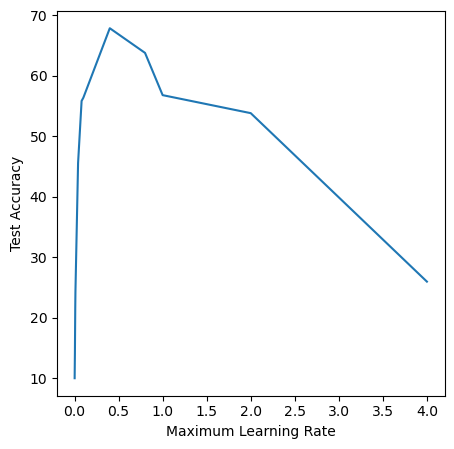

In [11]:
plot_max_lr_vs_test_accuracy(max_lr_list,test_accuracy_list)

From the LR Range Test found that maximum LR value of 0.4 gives Test Accuracy of 67.89 but maximum LR value of 0.8 gives Test accuracy of 63.81 in 5 epochs. So decided to take 0.4 as max LR

<!-- However maximum LR vlaue of 0.8, there is a steady increase of test accuracy over epochs compared to maximum LR value of 0.4 ,where there is a sudden increase. So decided to use maximum LR value of 0.8 -->

## 3. Define a Loss function and optimizer and train the model

Used Classification Cross-Entropy loss and SGD with momentum 0.9.

## 4. Train the model

 24 epochs are used to train the model. Used One Cycle LR policy for changing Learning Rates with maximum learning rate of 0.8. 

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [14]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import os

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")      
model = get_model(CustomResNet)
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
EPOCHS = 24

one_cyle_lr = custom_one_cycle_lr(no_of_images=50176, batch_size=BATCH_SIZE, base_lr=0.04, max_lr=0.4, final_lr=0.004, epoch_stage1=5, epoch_stage2=18, total_epochs=24)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[one_cyle_lr])
PATH = 'G:/ERA_S10/cifar10_resnet18_one_cyclic_lr_final_2.pth'
torch.save(model.state_dict(), PATH)
best_test_accuracy = 0.0
train_model(best_test_accuracy,EPOCHS, model,trainloader,testloader,optimizer,train,test,train_losses,test_losses,scheduler,train_acc,test_acc,PATH)


EPOCH: 1


Loss=1.4054405689239502 Batch_id=97 Accuracy=38.15: 100%|██████████████████████████████| 98/98 [19:23<00:00, 11.87s/it]



Test set: Average loss: 1.3386, Accuracy: 5165/10000 (51.65%)

Test Accuracy: 51.65 has increased. Saving the model
EPOCH: 2


Loss=1.1650360822677612 Batch_id=97 Accuracy=56.08: 100%|██████████████████████████████| 98/98 [18:19<00:00, 11.22s/it]



Test set: Average loss: 1.2167, Accuracy: 5929/10000 (59.29%)

Test Accuracy: 59.29 has increased. Saving the model
EPOCH: 3


Loss=0.9054064750671387 Batch_id=97 Accuracy=65.35: 100%|██████████████████████████████| 98/98 [18:16<00:00, 11.19s/it]



Test set: Average loss: 1.2410, Accuracy: 6366/10000 (63.66%)

Test Accuracy: 63.66 has increased. Saving the model
EPOCH: 4


Loss=0.6501558423042297 Batch_id=97 Accuracy=69.89: 100%|██████████████████████████████| 98/98 [18:28<00:00, 11.31s/it]



Test set: Average loss: 1.0491, Accuracy: 6741/10000 (67.41%)

Test Accuracy: 67.41 has increased. Saving the model
EPOCH: 5


Loss=0.7812561988830566 Batch_id=97 Accuracy=73.30: 100%|██████████████████████████████| 98/98 [18:23<00:00, 11.26s/it]



Test set: Average loss: 1.0351, Accuracy: 6802/10000 (68.02%)

Test Accuracy: 68.02 has increased. Saving the model
EPOCH: 6


Loss=0.5779283046722412 Batch_id=97 Accuracy=75.66: 100%|██████████████████████████████| 98/98 [26:10<00:00, 16.03s/it]



Test set: Average loss: 0.6385, Accuracy: 7954/10000 (79.54%)

Test Accuracy: 79.54 has increased. Saving the model
EPOCH: 7


Loss=0.5169624090194702 Batch_id=97 Accuracy=80.83: 100%|██████████████████████████████| 98/98 [28:44<00:00, 17.60s/it]



Test set: Average loss: 0.6743, Accuracy: 7903/10000 (79.03%)

EPOCH: 8


Loss=0.5057158470153809 Batch_id=97 Accuracy=83.27: 100%|████████████████████████████| 98/98 [1:40:45<00:00, 61.69s/it]



Test set: Average loss: 0.5354, Accuracy: 8265/10000 (82.65%)

Test Accuracy: 82.65 has increased. Saving the model
EPOCH: 9


Loss=0.5431559681892395 Batch_id=97 Accuracy=84.95: 100%|██████████████████████████████| 98/98 [28:39<00:00, 17.54s/it]



Test set: Average loss: 0.5575, Accuracy: 8277/10000 (82.77%)

Test Accuracy: 82.77 has increased. Saving the model
EPOCH: 10


Loss=0.374535471200943 Batch_id=97 Accuracy=86.42: 100%|███████████████████████████████| 98/98 [28:11<00:00, 17.26s/it]



Test set: Average loss: 0.5476, Accuracy: 8356/10000 (83.56%)

Test Accuracy: 83.56 has increased. Saving the model
EPOCH: 11


Loss=0.2935529947280884 Batch_id=97 Accuracy=87.98: 100%|██████████████████████████████| 98/98 [20:03<00:00, 12.28s/it]



Test set: Average loss: 0.4151, Accuracy: 8707/10000 (87.07%)

Test Accuracy: 87.07 has increased. Saving the model
EPOCH: 12


Loss=0.3904399871826172 Batch_id=97 Accuracy=88.91: 100%|██████████████████████████████| 98/98 [18:22<00:00, 11.25s/it]



Test set: Average loss: 0.4396, Accuracy: 8657/10000 (86.57%)

EPOCH: 13


Loss=0.259694904088974 Batch_id=97 Accuracy=90.09: 100%|███████████████████████████████| 98/98 [19:15<00:00, 11.80s/it]



Test set: Average loss: 0.4292, Accuracy: 8630/10000 (86.30%)

EPOCH: 14


Loss=0.19830873608589172 Batch_id=97 Accuracy=91.14: 100%|█████████████████████████████| 98/98 [18:50<00:00, 11.54s/it]



Test set: Average loss: 0.4163, Accuracy: 8734/10000 (87.34%)

Test Accuracy: 87.34 has increased. Saving the model
EPOCH: 15


Loss=0.2550513446331024 Batch_id=97 Accuracy=92.16: 100%|██████████████████████████████| 98/98 [20:19<00:00, 12.44s/it]



Test set: Average loss: 0.3716, Accuracy: 8833/10000 (88.33%)

Test Accuracy: 88.33 has increased. Saving the model
EPOCH: 16


Loss=0.24679633975028992 Batch_id=97 Accuracy=92.92: 100%|█████████████████████████████| 98/98 [19:18<00:00, 11.82s/it]



Test set: Average loss: 0.3422, Accuracy: 8908/10000 (89.08%)

Test Accuracy: 89.08 has increased. Saving the model
EPOCH: 17


Loss=0.15838994085788727 Batch_id=97 Accuracy=93.67: 100%|█████████████████████████████| 98/98 [18:52<00:00, 11.56s/it]



Test set: Average loss: 0.3474, Accuracy: 8937/10000 (89.37%)

Test Accuracy: 89.37 has increased. Saving the model
EPOCH: 18


Loss=0.14695632457733154 Batch_id=97 Accuracy=94.07: 100%|█████████████████████████████| 98/98 [18:17<00:00, 11.20s/it]



Test set: Average loss: 0.3240, Accuracy: 8997/10000 (89.97%)

Test Accuracy: 89.97 has increased. Saving the model
EPOCH: 19


Loss=0.15209412574768066 Batch_id=97 Accuracy=94.52: 100%|█████████████████████████████| 98/98 [18:16<00:00, 11.18s/it]



Test set: Average loss: 0.3231, Accuracy: 9022/10000 (90.22%)

Test Accuracy: 90.22 has increased. Saving the model
EPOCH: 20


Loss=0.16260682046413422 Batch_id=97 Accuracy=94.78: 100%|█████████████████████████████| 98/98 [18:08<00:00, 11.10s/it]



Test set: Average loss: 0.3227, Accuracy: 9015/10000 (90.15%)

EPOCH: 21


Loss=0.19812676310539246 Batch_id=97 Accuracy=95.01: 100%|█████████████████████████████| 98/98 [18:10<00:00, 11.12s/it]



Test set: Average loss: 0.3196, Accuracy: 9035/10000 (90.35%)

Test Accuracy: 90.35 has increased. Saving the model
EPOCH: 22


Loss=0.16771432757377625 Batch_id=97 Accuracy=95.13: 100%|█████████████████████████████| 98/98 [18:09<00:00, 11.12s/it]



Test set: Average loss: 0.3207, Accuracy: 9031/10000 (90.31%)

EPOCH: 23


Loss=0.14829200506210327 Batch_id=97 Accuracy=95.35: 100%|█████████████████████████████| 98/98 [18:14<00:00, 11.17s/it]



Test set: Average loss: 0.3206, Accuracy: 9006/10000 (90.06%)

EPOCH: 24


Loss=0.16676609218120575 Batch_id=97 Accuracy=95.26: 100%|█████████████████████████████| 98/98 [18:05<00:00, 11.08s/it]



Test set: Average loss: 0.3197, Accuracy: 9025/10000 (90.25%)



## Load the Best Model

In [15]:
model.load_state_dict(torch.load(PATH))
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.device = torch.device("cuda" if use_cuda else "cpu")


## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


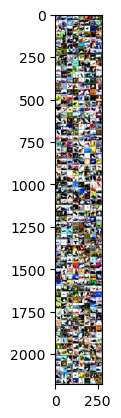

In [18]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [19]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [20]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [21]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

Accuracy of the network on the 10000 test images: 90.35 %




The accuracy 90.35 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [22]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 75 %
Accuracy of  deer : 100 %
Accuracy of   dog : 66 %
Accuracy of  frog : 90 %
Accuracy of horse : 83 %
Accuracy of  ship : 91 %
Accuracy of truck : 100 %


## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Accuracy
ii. Test Accuracy

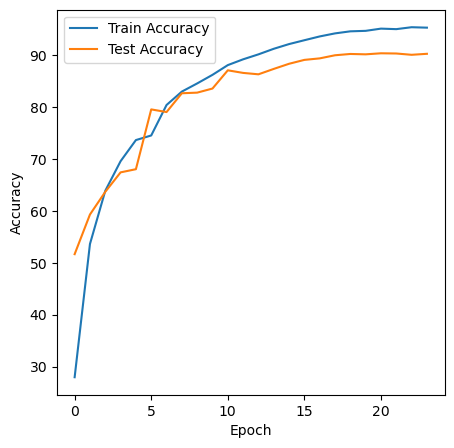

In [23]:
plot_accuracy(train_acc, test_acc)
